<div style="background-color: RGB(1,44,197); text-align: center;">
  <h1 style="margin: auto; padding: 20px; color: #fff;">Détectez des faux billets avec Python - Classification</h1>
</div>

Dans ce notebook, nous allons tester plusieurs algorithmes pour détecter les faux billets.

# Import librairies et jeux de données

In [1]:
import pandas as pd
import numpy as np

#pour exporter le modèle
import joblib

#pour les représentations graphiques
import seaborn as sns
import matplotlib.pyplot as plt

#pour centrer-réduire
from sklearn.preprocessing import StandardScaler

#pour les modèles non-supervisés
from sklearn.cluster import KMeans

#pour les modèles supervisés
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#Pour évaluer les performances des modèles
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn import metrics

In [2]:
df_scaled = pd.read_csv("df_scaled.csv", sep=',')
df = pd.read_csv("df.csv", sep=',')

In [3]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


# Définition X et y et division train/test

In [4]:
# Définit X et y
X = df.drop(columns='is_genuine')
y = df['is_genuine']

# Sépare les données en entraînement et test. J'utilise l'argument stratify pour être sûre qu'il y a la même proportion de faux billets dans X_test et X_train.
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.4, 
    random_state=42,
    stratify=y
)

In [5]:
# Standardise les données d'entrainement
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [6]:
#On standardise les données de test. On n'utilise que le transform car le scaler a déjà été fit sur les données d'entraînement.
X_test_scaled = scaler.transform(X_test)

# Définition des métriques

Pour comparer les différents algorithmes, nous allons utiliser les métriques suivantes qui sont adaptées aux problèmes de classification:<br>
-L'**accuracy** correspond au nombre d'échantillons qui ont été correctement classés (échantillons biens classés / échantillons totaux)<br>
-Le **rappel** est adapté pour minimiser les faux négatifs, quand les conséquences de manquer des instances positives sont graves (TP/TP+FN)<br>
-La **précision** est adaptée quand on souhaite minimiser les faux positifs. (TP/TP+FP)<br>
-Le **f1** permet de résumer les informations de précision et rappel en une seule métrique

In [7]:
def save_classifier_metrics(y_true, y_pred, clf_label):
    '''Sauvegarde et affiche les métriques dans un dictionnaire.
    Paramètres :
    - y_true : la vraie valeur des labels
    - y_pred : les labels prédits par la méthode de classification
    - clf_label : le nom de la méthode de classification
    '''

    if not('clf_metrics_dict' in globals()):  
        global clf_metrics_dict
        clf_metrics_dict = {
            'accuracy': {}, 'precision': {}, 'recall': {}, 'f1-score': {}}
        
    clf_metrics_dict['accuracy'].update(
        {clf_label: metrics.accuracy_score(y_true, y_pred)})
    
    clf_metrics_dict['precision'].update(
        {clf_label: metrics.precision_score(
            y_true, y_pred)}
    )
    
    clf_metrics_dict['recall'].update(
        {clf_label: metrics.recall_score(
            y_true, y_pred)}
    )
    
    clf_metrics_dict['f1-score'].update(
        {clf_label: metrics.f1_score(
            y_true, y_pred)}
    )

    return pd.DataFrame(clf_metrics_dict)

# Kmeans

On va commencer par prédire la véracité des billets avec un Kmeans. Le Kmeans est une technique d'apprentissage non supervisée dans laquelle l'algorithme va essayer de déterminer des clusters homogènes dans les données.

## Application du Kmeans

In [8]:
#Je récupère les centroïdes de mon jeu de données complet
mean_values = df_scaled.groupby('is_genuine').mean()
#je tranforme en array pour pouvoir le passer en argument de mon modèle
centroids = mean_values.values

In [9]:
# Entraînement du modèle
clf_kmeans = KMeans(n_clusters=2, init=centroids, n_init=1, random_state=42)
clf_kmeans.fit(X_train_scaled)

KMeans(init=array([[-0.1877458 ,  0.53716487,  0.68602344,  1.10802031,  0.85738431,
        -1.20106985],
       [ 0.0938729 , -0.26858243, -0.34301172, -0.55401016, -0.42869216,
         0.60053492]]),
       n_clusters=2, n_init=1, random_state=42)

Nous voulons désormais comparer les résultats obtenus avec le clustering en comparaison aux résultats stockés dans la colonne 'is_genuine'

## Mesures de performance

In [10]:
#On effectue la prédiction sur les données de test
y_pred = clf_kmeans.predict(X_test_scaled)

In [11]:
save_classifier_metrics(y_test, y_pred, 'k-means')

,accuracy,precision,recall,f1-score
k-means,0.986667,0.987562,0.9925,0.990025


## Matrice de confusion

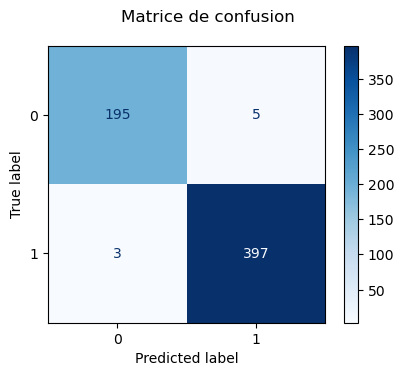

In [12]:
# On trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

In [13]:
#On peut vérifier cette interprétation en regroupant y_test et y_pred dans un dataframe
df_resultats = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
}, index=y_test.index)

In [14]:
#faux negatifs
df_resultats.loc[(df_resultats['y_test'] == 1) & (df_resultats['y_pred'] == 0)].count()

y_test    3
y_pred    3
dtype: int64

In [15]:
#faux positifs
df_resultats.loc[(df_resultats['y_test'] == 0) & (df_resultats['y_pred'] == 1)].count()

y_test    5
y_pred    5
dtype: int64

## Exemple avec un nouveau billet

In [16]:
mean_values

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
0,-0.187746,0.537165,0.686023,1.10802,0.857384,-1.201070
1,0.093873,-0.268582,-0.343012,-0.55401,-0.428692,0.600535


In [17]:
#on crée un nouveau billet avec les dimensions moyenne d'un vrai billet pour voir si la classification est bonne
nouveau_billet = np.array([[0.09, -0.27, -0.34, -0.55, -0.43, 0.6]])

In [18]:
# Prédiction du cluster
cluster = clf_kmeans.predict(nouveau_billet)
cluster

array([1])

la prédiction est bonne

In [19]:
#on crée un nouveau billet avec les dimensions moyenne d'un faux billet pour voir si la classification est bonne
nouveau_billet = np.array([[-0.19, 0.54, 0.69, 1.11, 0.86, -1.2]])

In [20]:
# Prédiction du cluster
cluster = clf_kmeans.predict(nouveau_billet)
cluster

array([0])

la prédiction est bonne

## Validation croisée

On vérifie la qualité des résultats du kmeans grâce à une validation croisée.

In [21]:
# Calcul 'f1' pour 5 'folds'
scores = cross_val_score(
    KMeans(n_clusters=2, init=centroids, n_init=1, random_state=42),
    X_train_scaled, y_train, cv=5, scoring='f1'
)

scores

C:\Users\Pauline NANDELEC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Pauline NANDELEC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Pauline NANDELEC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Pauline NANDELEC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMe

array([0.99578059, 0.99145299, 0.99173554, 0.98360656, 0.98373984])

Les résultats changent en fonction des données ce qui peut nous faire douter sur la fiabilité du modèle.

# Régression logistique

La régression logistique est utilisée pour prédire la probabilité d'appartenance à une classe (souvent binaire) en fonction de variables explicatives, en appliquant une fonction logistique pour obtenir une sortie comprise entre 0 et 1.

J'ai choisi d'utiliser la régression logistique de sklearn et non pas de statsmodels car mon objectif est ici d'optimiser la prédiction et non pas d'interpréter les p-values, les coefficients etc...
Si j'avais voulu faire de la sélection de variables j'aurai pu utiliser la fonction summary() de statsmodels après avoir entraîné ma régression logistique. Cependant comme j'ai fait mon kmeans avec toutes les variables et que je souhaite comparer mes 2 modèles, je ne fais pas de sélection de variable.

## Entraînement du modèle

In [22]:
#initialisation et entraînement du modèle
clf_reg_log = LogisticRegression(random_state=808).fit(X_train_scaled, y_train)

In [23]:
# Affiche les coefficients de la régression
for column, coef in zip(X.columns, clf_reg_log.coef_[0]):
    print(f'{column} : \t{coef:>9.6f}')

diagonal : 	 0.244234
height_left : 	-0.400689
height_right : 	-0.715854
margin_low : 	-2.324088
margin_up : 	-1.480090
length : 	 3.545823


Le coefficient le plus élevé est celui de la longueur. En effet, nous avions vu dans les analyses descriptives que la longueur était la caractéristique physique qui différenciait le mieux les vrais des faux billets.

## Mesures de perfomance

In [24]:
#On effectue la prédiction sur les données de test
y_pred = clf_reg_log.predict(X_test_scaled)

<Axes: ylabel='Count'>

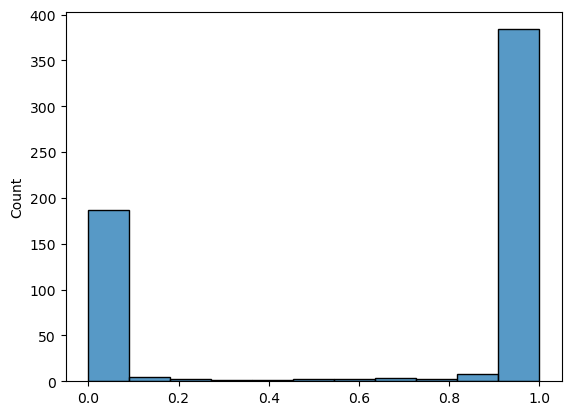

In [25]:
#histogramme des probabilités de prédiction

y_hat_proba = clf_reg_log.predict_proba(X_test_scaled)[:,1]
sns.histplot(y_hat_proba)

Le modèle est assez confiant de ses prédiction, la plupart des prédictions ont une probabilité proche de 0 ou de 1

C'est un très bon score

In [26]:
save_classifier_metrics(y_test, y_pred, 'régression logisitique')

,accuracy,precision,recall,f1-score
k-means,0.986667,0.987562,0.9925,0.990025
régression logisitique,0.993333,0.992537,0.9975,0.995012


## Matrice de confusion

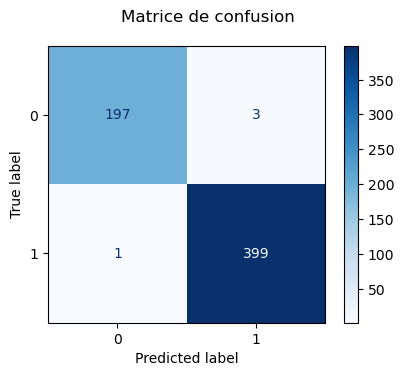

In [27]:
# On trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

On obtient un score meilleur que pour le kmeans qui avait 5 faux positifs et 3 faux négatifs.

## Sélection des hyperparamètres et validation croisée

1) On choisit les types de pénalisations qu'on peut appliquer pour une régression logisitique: l1 ou l2. Par rapport à la taille du jeu de données et le nombre de features, on chosit l2.
2) Comme solver, on en choisit un qui est compatible avec les types de pénalisations qu'on veut tester. 'liblinear' et 'saga' sont compatibles, mais on choisit uniquement liblinear qui est plus adapté pour des petits datasets.
3) On teste plusieurs valeurs pour C qui contrôle la force de régularisation. Les valeurs vont de 0.01 (très forte régularisation) à 100 (très faible régularisation).

In [36]:
#On définit les paramètres de la fonction GridSearchCV

model = LogisticRegression(max_iter=1000, random_state = 6)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

In [46]:
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='f1'
)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=6),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['liblinear']},
             scoring='f1')

In [47]:
print("Meilleurs hyperparamètres :", grid.best_params_)
print("Score de validation croisée :", grid.best_score_)

Meilleurs hyperparamètres : {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Score de validation croisée : 0.9917011876593168


In [48]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_scaled)

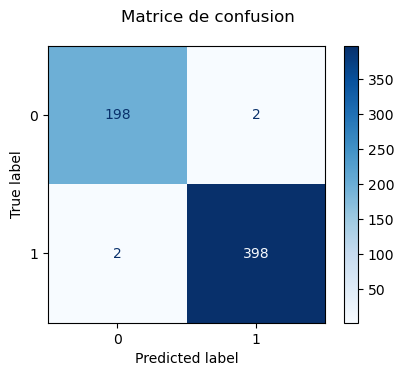

In [49]:
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

In [50]:
save_classifier_metrics(y_test, y_pred, 'régression logisitique avec GridSearchCV')

,accuracy,precision,recall,f1-score
k-means,0.986667,0.987562,0.9925,0.990025
régression logisitique,0.993333,0.992537,0.9975,0.995012
régression logisitique avec GridSearchCV,0.993333,0.995000,0.9950,0.995000


# Comparaison des 2 méthodes

Sachant que l'on souhaite minimiser les faux positifs, je choisis le modèle qui a le score de précision le plus élevé c'est--à-dire **Régression logistique avec GridSearchCV**

In [45]:
#On exporte le modèle
joblib.dump(best_model, "prediction_billet.joblib")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']